<h1>Recommender system - movie review</h1>

- dataset : MovieLens 100k
- Task: generate a recommender system that gets a user id and generates top k movie titles as recommenation
- Model: deep learning MLP
- steps
    - employ the model and users-ratings dataset, train the model
    - for a given user and movies the user has not yet seen as input, generate prediction (ratings)
    - sort ratings and produce the top-k ones as the recommendations for the user.



<img src="RecommenderSytems_1.png" width="400" height="350">

In [108]:
import pandas as pd
import numpy as np
import random, os, gc, math, copy
from pathlib import Path
from sklearn.model_selection import train_test_split

from itertools import zip_longest


import torch
from torch import nn
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [7]:
def random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

random_seed(3407)

# Load data - EDA - preprocess

Datasets:
- movies.csv: movie metadata
- ratings.csv: user ratings

Preprocessing
- add 'title' from movies to ratings; use ratings as the dataset to train model on
- 


In [12]:
root = Path(r'C:\Work\PyTorch\data\MovieLense_100k')
print(os.listdir(root))

['links.csv', 'movies.csv', 'ratings.csv', 'README.txt', 'tags.csv']


In [14]:
movies = pd.read_csv(os.path.join(root, 'movies.csv'))
ratings = pd.read_csv(os.path.join(root , 'ratings.csv'))
tags = pd.read_csv(os.path.join(root , 'tags.csv'))
movies.shape, ratings.shape, tags.shape

((9742, 3), (100836, 4), (3683, 4))

In [18]:
with pd.option_context('display.max_colwidth', None
                      , 'display.max_columns', None
                      , 'display.max_rows', None):
    display('movies',movies.head(2),'ratings', ratings.head(2),'tags', tags.head(2))

'movies'

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


'ratings'

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


'tags'

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


__Examine target__

In [19]:
minmax = ratings.rating.min(), ratings.rating.max()
minmax

(0.5, 5.0)

__Merge movies and ratings, by movieId__

In [22]:
ratings = ratings.merge(movies[['movieId', 'title']], on ='movieId' )
ratings.head(3)

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,1,3,4.0,964981247,Grumpier Old Men (1995)
2,1,6,4.0,964982224,Heat (1995)


# Custom dataset and dataloadder

In [101]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
        
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)


(n, m), (X, y), (user_to_index, movie_to_index) = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 610 users, 9724 movies
Dataset shape: (100836, 2)
Target shape: (100836,)


In [102]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [103]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [104]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 329,  728],
        [ 369,  753],
        [ 274, 6350],
        [ 238, 2319]])
tensor([[3.5000],
        [4.5000],
        [5.0000],
        [4.0000]])


In [106]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=3407)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

# Model

In [89]:
import torch
import torch.nn as nn
from itertools import zip_longest

class Embedding_recommender(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=50, embedding_dropout=0.03, hidden=10, dropouts=0.2):
        super(Embedding_recommender, self).__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def generate_layers(n_in):
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
    
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(generate_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()

    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out * (max_rating - min_rating + 1) + min_rating - 0.5
        return out

    def _init(self):
        '''
        Initialize weights.
        '''
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)

def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuration should be a single number or a list of numbers')


In [92]:
model = Embedding_recommender(n_users = n_users,
                              n_movies = n_movies,
                              n_factors = 150,
                              hidden = [500,500,500],
                              embedding_dropout = 0.05,
                              dropouts = [0.5,0.5,0.25]
                             )
model

Embedding_recommender(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

# Train

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import copy
from tqdm import tqdm

# Parameters
lr = 1e-5
wd = 1e-5
bs = 200
n_epochs = 200
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []

# Assuming 'model', 'device', 'dataset_sizes', 'datasets', and 'batches' are already defined
model.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        batch_num = 0
        pbar = tqdm(batches(*datasets[phase], shuffle=training, bs=bs), total=iterations_per_epoch, desc=f'Epoch {epoch+1}/{n_epochs} [{phase}]')

        for batch in pbar:
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = model(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item()
            batch_num += 1
            pbar.set_postfix({'loss': running_loss / (batch_num * bs)})
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(model.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break


Epoch 1/200 [val]:  25%|████████████▏                                    | 100/403 [00:00<00:01, 167.51it/s, loss=1.08]


loss improvement on epoch: 1
[001/200] train: 1.1776 - val: 1.0737


Epoch 2/200 [val]:  25%|████████████▏                                    | 100/403 [00:00<00:01, 177.96it/s, loss=1.07]


loss improvement on epoch: 2
[002/200] train: 1.0803 - val: 1.0606


Epoch 3/200 [val]:  25%|████████████▏                                    | 100/403 [00:00<00:01, 181.31it/s, loss=1.05]


loss improvement on epoch: 3
[003/200] train: 1.0633 - val: 1.0400


Epoch 4/200 [val]:  25%|████████████▏                                    | 100/403 [00:00<00:02, 139.64it/s, loss=1.02]


loss improvement on epoch: 4
[004/200] train: 1.0394 - val: 1.0094


Epoch 5/200 [val]:  25%|███████████▉                                    | 100/403 [00:00<00:02, 145.33it/s, loss=0.977]


loss improvement on epoch: 5
[005/200] train: 1.0029 - val: 0.9693


Epoch 6/200 [val]:  25%|███████████▉                                    | 100/403 [00:00<00:02, 135.11it/s, loss=0.929]


loss improvement on epoch: 6
[006/200] train: 0.9555 - val: 0.9213


Epoch 7/200 [val]:  25%|███████████▉                                    | 100/403 [00:00<00:02, 137.27it/s, loss=0.898]


loss improvement on epoch: 7
[007/200] train: 0.9129 - val: 0.8903


Epoch 8/200 [val]:  25%|███████████▉                                    | 100/403 [00:00<00:01, 182.50it/s, loss=0.878]


loss improvement on epoch: 8
[008/200] train: 0.8824 - val: 0.8710


Epoch 9/200 [val]:  25%|███████████▉                                    | 100/403 [00:00<00:01, 169.68it/s, loss=0.859]


loss improvement on epoch: 9
[009/200] train: 0.8584 - val: 0.8523


Epoch 10/200 [val]:  25%|███████████▉                                    | 100/403 [00:00<00:01, 216.62it/s, loss=0.85]


loss improvement on epoch: 10
[010/200] train: 0.8413 - val: 0.8433


Epoch 11/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 201.23it/s, loss=0.837]


loss improvement on epoch: 11
[011/200] train: 0.8232 - val: 0.8301


Epoch 12/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 197.67it/s, loss=0.831]


loss improvement on epoch: 12
[012/200] train: 0.8089 - val: 0.8240


Epoch 13/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 228.91it/s, loss=0.822]


loss improvement on epoch: 13
[013/200] train: 0.7969 - val: 0.8150


Epoch 14/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 227.75it/s, loss=0.816]


loss improvement on epoch: 14
[014/200] train: 0.7836 - val: 0.8096


Epoch 15/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 160.89it/s, loss=0.811]


loss improvement on epoch: 15
[015/200] train: 0.7719 - val: 0.8047


Epoch 16/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 206.50it/s, loss=0.811]


loss improvement on epoch: 16
[016/200] train: 0.7604 - val: 0.8039


Epoch 17/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 207.15it/s, loss=0.803]


loss improvement on epoch: 17
[017/200] train: 0.7520 - val: 0.7967


Epoch 18/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 141.17it/s, loss=0.798]


loss improvement on epoch: 18
[018/200] train: 0.7432 - val: 0.7911


Epoch 19/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 213.47it/s, loss=0.796]


loss improvement on epoch: 19
[019/200] train: 0.7351 - val: 0.7893


Epoch 20/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 173.88it/s, loss=0.792]


loss improvement on epoch: 20
[020/200] train: 0.7288 - val: 0.7856


Epoch 21/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 206.41it/s, loss=0.792]


loss improvement on epoch: 21
[021/200] train: 0.7225 - val: 0.7856


Epoch 22/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 177.57it/s, loss=0.783]


loss improvement on epoch: 22
[022/200] train: 0.7145 - val: 0.7763


Epoch 23/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 201.65it/s, loss=0.784]


[023/200] train: 0.7089 - val: 0.7770


Epoch 24/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 164.39it/s, loss=0.783]


[024/200] train: 0.7039 - val: 0.7764


Epoch 25/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 150.93it/s, loss=0.781]


loss improvement on epoch: 25
[025/200] train: 0.6990 - val: 0.7748


Epoch 26/200 [val]:  25%|███████████▉                                    | 100/403 [00:00<00:01, 181.17it/s, loss=0.78]


loss improvement on epoch: 26
[026/200] train: 0.6938 - val: 0.7738


Epoch 27/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 145.95it/s, loss=0.782]


[027/200] train: 0.6884 - val: 0.7751


Epoch 28/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 194.29it/s, loss=0.778]


loss improvement on epoch: 28
[028/200] train: 0.6855 - val: 0.7719


Epoch 29/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 151.37it/s, loss=0.778]


loss improvement on epoch: 29
[029/200] train: 0.6806 - val: 0.7716


Epoch 30/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 171.26it/s, loss=0.781]


[030/200] train: 0.6771 - val: 0.7741


Epoch 31/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 205.93it/s, loss=0.775]


loss improvement on epoch: 31
[031/200] train: 0.6748 - val: 0.7686


Epoch 32/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 191.06it/s, loss=0.776]


[032/200] train: 0.6696 - val: 0.7696


Epoch 33/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 203.94it/s, loss=0.774]


loss improvement on epoch: 33
[033/200] train: 0.6671 - val: 0.7679


Epoch 34/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 195.79it/s, loss=0.775]


[034/200] train: 0.6644 - val: 0.7685


Epoch 35/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 200.84it/s, loss=0.776]


[035/200] train: 0.6618 - val: 0.7696


Epoch 36/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 109.64it/s, loss=0.776]


[036/200] train: 0.6593 - val: 0.7691


Epoch 37/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 115.76it/s, loss=0.774]


loss improvement on epoch: 37
[037/200] train: 0.6578 - val: 0.7671


Epoch 38/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 162.28it/s, loss=0.775]


[038/200] train: 0.6564 - val: 0.7681


Epoch 39/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 163.73it/s, loss=0.772]


loss improvement on epoch: 39
[039/200] train: 0.6530 - val: 0.7655


Epoch 40/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 181.35it/s, loss=0.775]


[040/200] train: 0.6511 - val: 0.7681


Epoch 41/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 191.23it/s, loss=0.772]


[041/200] train: 0.6491 - val: 0.7656


Epoch 42/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 192.88it/s, loss=0.775]


[042/200] train: 0.6477 - val: 0.7686


Epoch 43/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 181.67it/s, loss=0.775]


[043/200] train: 0.6465 - val: 0.7687


Epoch 44/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 179.29it/s, loss=0.773]


[044/200] train: 0.6439 - val: 0.7670


Epoch 45/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 187.32it/s, loss=0.771]


loss improvement on epoch: 45
[045/200] train: 0.6420 - val: 0.7644


Epoch 46/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 162.11it/s, loss=0.771]


[046/200] train: 0.6410 - val: 0.7644


Epoch 47/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 188.86it/s, loss=0.773]


[047/200] train: 0.6392 - val: 0.7670


Epoch 48/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 174.24it/s, loss=0.776]


[048/200] train: 0.6360 - val: 0.7697


Epoch 49/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 154.35it/s, loss=0.773]


[049/200] train: 0.6367 - val: 0.7661


Epoch 50/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 162.29it/s, loss=0.769]


loss improvement on epoch: 50
[050/200] train: 0.6350 - val: 0.7628


Epoch 51/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 187.77it/s, loss=0.774]


[051/200] train: 0.6340 - val: 0.7676


Epoch 52/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 199.18it/s, loss=0.775]


[052/200] train: 0.6315 - val: 0.7687


Epoch 53/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 199.93it/s, loss=0.771]


[053/200] train: 0.6306 - val: 0.7643


Epoch 54/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 118.39it/s, loss=0.773]


[054/200] train: 0.6292 - val: 0.7662


Epoch 55/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 108.81it/s, loss=0.768]


loss improvement on epoch: 55
[055/200] train: 0.6283 - val: 0.7612


Epoch 56/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 116.05it/s, loss=0.773]


[056/200] train: 0.6258 - val: 0.7662


Epoch 57/200 [val]:  25%|███████████▉                                    | 100/403 [00:01<00:03, 90.45it/s, loss=0.773]


[057/200] train: 0.6245 - val: 0.7668


Epoch 58/200 [val]:  25%|███████████▉                                    | 100/403 [00:01<00:03, 82.84it/s, loss=0.774]


[058/200] train: 0.6230 - val: 0.7673


Epoch 59/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 181.62it/s, loss=0.773]


[059/200] train: 0.6226 - val: 0.7666


Epoch 60/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 103.35it/s, loss=0.766]


loss improvement on epoch: 60
[060/200] train: 0.6250 - val: 0.7599


Epoch 61/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 153.29it/s, loss=0.772]


[061/200] train: 0.6217 - val: 0.7652


Epoch 62/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:02, 105.13it/s, loss=0.774]


[062/200] train: 0.6204 - val: 0.7679


Epoch 63/200 [val]:  25%|███████████▉                                    | 100/403 [00:01<00:03, 96.17it/s, loss=0.775]


[063/200] train: 0.6168 - val: 0.7687


Epoch 64/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 180.82it/s, loss=0.773]


[064/200] train: 0.6181 - val: 0.7661


Epoch 65/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 183.53it/s, loss=0.775]


[065/200] train: 0.6164 - val: 0.7681


Epoch 66/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 172.62it/s, loss=0.771]


[066/200] train: 0.6151 - val: 0.7649


Epoch 67/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 174.28it/s, loss=0.773]


[067/200] train: 0.6155 - val: 0.7662


Epoch 68/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 183.57it/s, loss=0.775]


[068/200] train: 0.6133 - val: 0.7681


Epoch 69/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 181.11it/s, loss=0.773]


[069/200] train: 0.6128 - val: 0.7662


Epoch 70/200 [val]:  25%|███████████▋                                   | 100/403 [00:00<00:01, 179.98it/s, loss=0.773]

[070/200] train: 0.6118 - val: 0.7663
early stopping after epoch 070


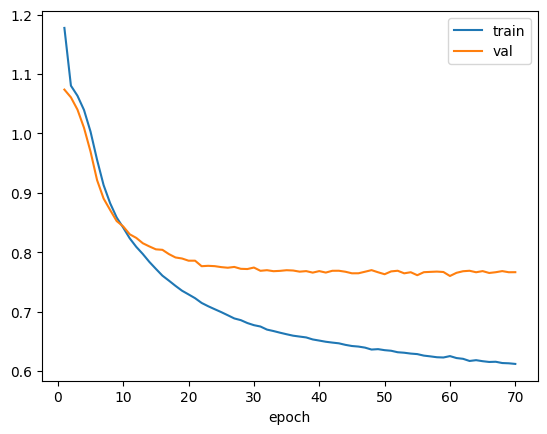

In [110]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

# Validation

In [111]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = model(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

final_loss = np.sqrt(np.mean((np.array(predictions) - np.array(groud_truth))**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8786


# Build recommendation system

In [112]:
device="cpu"
def recommender_system(user_id, model, n_movies):
    model = model.to(device)
    seen_movies = set(X[X['user_id'] == user_id]['movie_id'])
    print(f"Total movies seen by the user: {len(seen_movies)}")
    user_ratings = y[X['user_id'] == user_id]
    print("=====================================================================")
    print(f"Some top rated movies (rating = {user_ratings.max()}) seen by the user:")
    print("=====================================================================\n")
    top_rated_movie_ids = X.loc[(X['user_id'] == user_id) & (y == user_ratings.max()), "movie_id"]
    print("\n".join(movies[movies.movieId.isin(top_rated_movie_ids)].title.iloc[:10].tolist()))
    print("")
    
    unseen_movies = list(set(ratings.movieId) - set(seen_movies))
    unseen_movies_index = [movie_to_index[i] for i in unseen_movies]
    
    model_input = (torch.tensor([user_id]*len(unseen_movies_index), device=device), 
                   torch.tensor(unseen_movies_index, device=device))
    
    with torch.no_grad():
        predicted_ratings = model(*model_input, minmax).detach().numpy()
    
    zipped_pred = zip(unseen_movies, predicted_ratings)
    sorted_movie_index = list(zip(*sorted(zipped_pred, key=lambda c: c[1], reverse=True)))[0]
    recommended_movies = movies[movies.movieId.isin(sorted_movie_index)].title.tolist()
    
    print("=====================================================================")
    print("Top "+str(n_movies)+" Movie recommendations for the user "+str(user_id)+ " are:")
    print("=====================================================================\n")
    print("\n".join(recommended_movies[:n_movies]))

In [118]:
recommender_system(110, model, 20)

Total movies seen by the user: 646
Some top rated movies (rating = 5.0) seen by the user:

Money Train (1995)
Waterworld (1995)
French Kiss (1995)
Goofy Movie, A (1995)
I.Q. (1994)
Victor/Victoria (1982)
Mediterraneo (1991)
Nightmare on Elm Street, A (1984)
Young Guns (1988)
I Went Down (1997)

Top 20 Movie recommendations for the user 110 are:

Toy Story (1995)
Jumanji (1995)
Grumpier Old Men (1995)
Waiting to Exhale (1995)
Father of the Bride Part II (1995)
Heat (1995)
Sabrina (1995)
Tom and Huck (1995)
Sudden Death (1995)
GoldenEye (1995)
American President, The (1995)
Dracula: Dead and Loving It (1995)
Balto (1995)
Nixon (1995)
Cutthroat Island (1995)
Casino (1995)
Sense and Sensibility (1995)
Four Rooms (1995)
Ace Ventura: When Nature Calls (1995)
Get Shorty (1995)
